In [1]:
from os import walk 
from os.path import join
import numpy as np 
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup 

from sklearn import svm
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay

import gensim
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

from collections import Counter

%matplotlib inline 

In [2]:
SPAM_1_FILEPATH = 'UniversityProject_SpamFilter/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_FILEPATH = 'UniversityProject_SpamFilter/01_Processing/spam_assassin_corpus/spam_2'
HAM_1_FILEPATH = 'UniversityProject_SpamFilter/01_Processing/spam_assassin_corpus/ham_1'
HAM_2_FILEPATH = 'UniversityProject_SpamFilter/01_Processing/spam_assassin_corpus/ham_2'

SPAM_CAT = 1
HAM_CAT = 0

CUSTOM_FONT = 'UniversityProject_SpamFilter/wordcloud_resources/OpenSansCondensed-Bold.ttf'
WORD_CLOUD = 'UniversityProject_SpamFilter/wordcloud_resources/word_cloud.png'
THUMBS_UP = 'UniversityProject_SpamFilter/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN = 'UniversityProject_SpamFilter/wordcloud_resources/thumbs-down.png'
X_ICON = 'UniversityProject_SpamFilter/wordcloud_resources/x-icon.png'

In [3]:
def email_body_generator(path): 
                                    #walk provides a tuple 
    for root, dirnames, filenames, in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            stream = open(filepath, encoding='latin-1')
            is_body= False
            lines = []
            
            #extracts email body 
            for line in stream: 
                if is_body: 
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            #loops over the file in the directory and returns the file name and associated email body 
            yield file_name, email_body

In [4]:
def dataframe_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name) 
    
    return pd.DataFrame(rows, index=row_names) 

In [5]:
spam_emails = dataframe_from_directory(SPAM_1_FILEPATH, SPAM_CAT)
spam_emails = spam_emails.append(dataframe_from_directory(SPAM_2_FILEPATH, SPAM_CAT))
ham_emails = dataframe_from_directory(HAM_1_FILEPATH, HAM_CAT)
ham_emails = ham_emails.append(dataframe_from_directory(HAM_2_FILEPATH, HAM_CAT))
data = pd.concat([spam_emails, ham_emails])

In [6]:
data

,MESSAGE,CATEGORY
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1
...,...,...
00609.dd49926ce94a1ea328cce9b62825bc97,"I'm one of the 30,000 but it's not working ver...",0
00957.e0b56b117f3ec5f85e432a9d2a47801f,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,0
01127.841233b48eceb74a825417d8d918abf8,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",0
01178.5c977dff972cd6eef64d4173b90307f0,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",0


In [7]:
data[data.MESSAGE.str.len() == 0].index


Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [8]:
data.drop(['cmds'], inplace = True)

In [9]:
data['length']=data['MESSAGE'].apply(len)
data

,MESSAGE,CATEGORY,length
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1,612
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1,1298
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1,6691
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1,1141
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1,1795
...,...,...,...
00609.dd49926ce94a1ea328cce9b62825bc97,"I'm one of the 30,000 but it's not working ver...",0,953
00957.e0b56b117f3ec5f85e432a9d2a47801f,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,0,257
01127.841233b48eceb74a825417d8d918abf8,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",0,393
01178.5c977dff972cd6eef64d4173b90307f0,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",0,1434


In [10]:
amount_of_SPAM = data.CATEGORY.value_counts()[1]
amount_of_HAM = data.CATEGORY.value_counts()[0]

In [11]:
amount_of_SPAM

1896

In [12]:
amount_of_HAM

3900

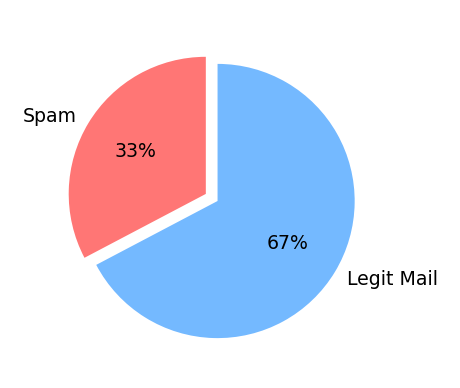

In [13]:
category_names =['Spam', 'Legit Mail']
size = [amount_of_SPAM, amount_of_HAM]
custom_colours = ['#ff7675', '#74b9ff']
plt.figure(figsize=(2, 2), dpi=227)
plt.pie(size, labels = category_names, textprops={'fontsize':6}, startangle=90, 
        autopct='%1.0f%%', colors = custom_colours, explode=[0,0.1])
plt.show()

In [14]:
documents_ids = range(0, len(data.index))
data['Doc_ID'] = documents_ids
data['File_Name'] = data.index
data = data.set_index('Doc_ID')
#data.head()

Examples of stop words in English are “a”, “the”, “is”, “are” and etc. 
Removing stop words is done to eliminate words that are so commonly used that they carry very little useful information.

The below, is adding multiple dictionaries from different libraries together, in addition to common html words found in the messages.

In [15]:
sklearn_stopwords = set(text.ENGLISH_STOP_WORDS)
gensim_stopwords = set(gensim.parsing.preprocessing.STOPWORDS)
nltk_stop_words = stopwords.words('english')

gensim_and_sklearn = sklearn_stopwords.union(gensim_stopwords)
libary_stopwords = gensim_and_sklearn.union(nltk_stop_words)

all_stop_words = {'url', 'http', '\n', '[html', 'html', 'tr', 'td', 'https', 'br', 'ign', 'err', 'mpt','[', ']' }
all_stop_words.update(libary_stopwords)

capital_sw = [each_string.title() for each_string in all_stop_words]
uppercase_sw = [each_string.upper() for each_string in all_stop_words]

all_stop_words.update(capital_sw)
all_stop_words.update(uppercase_sw)

#print(all_stop_words)

In [16]:
def clean_msg_nohtml(message, #stemmer = PorterStemmer(),
                  stop_words = set(all_stop_words)): 
    
    # Remove HTML tags 
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    #Converts to lower case and splots up  the individual words
    words = word_tokenize(cleaned_text)
    
    filtered_words = []
    
    for word in words: 
        if word not in stop_words and word.isalpha():
            filtered_words.append(word)
    
    return filtered_words

In [17]:
nested_list = data.MESSAGE.apply(clean_msg_nohtml)

/Users/rachaeldoherty/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [18]:
nested_list

Doc_ID
0       [Dear, Homeowner, Rates, lowest, point, years,...
1       [ATTENTION, Users, Package, Deal, Norton, Syst...
2       [message, MIME, format, dare, Try, better, ann...
3       [IMPORTANT, INFORMATION, new, domain, names, f...
4       [line, AWAY, CD, FREE, people, like, month, le...
                              ...                        
5791    [working, week, TES, updates, servers, syncing...
5792    [Damien, Morton, quoted, approves, able, feeli...
5793    [Mon, che, wrote, thats, correct, lines, added...
5794    [time, Manfred, wrote, like, install, RPM, tri...
5795    [run, Pick, use, New, FTOC, button, messages, ...
Name: MESSAGE, Length: 5796, dtype: object

In [19]:
docs_id_SPAM = data[data.CATEGORY ==1].index
docs_id_HAM = data[data.CATEGORY ==0].index

nested_list_HAM = nested_list.loc[docs_id_HAM]
nested_list_SPAM = nested_list.loc[docs_id_SPAM]
flat_list_HAM = [item for sublist in nested_list_HAM for item in sublist]

#total number of unique words in the non spam messages
HAM_words = pd.Series(flat_list_HAM).value_counts() 
flat_list_SPAM = [item for sublist in nested_list_SPAM for item in sublist]

#total number of unique words in the spam messages
SPAM_words = pd.Series(flat_list_SPAM).value_counts() 

In [20]:
SPAM_str = ' ' .join(flat_list_SPAM)
HAM_str = ' ' .join(flat_list_HAM)
full_str = SPAM_str + HAM_str

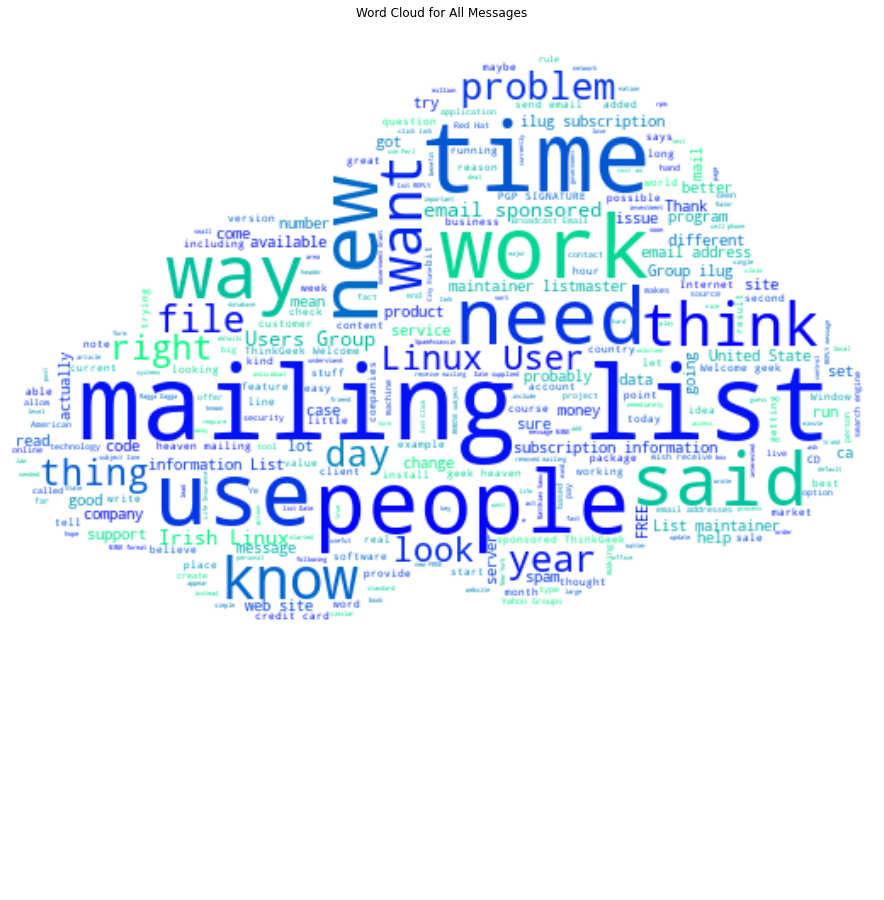

In [21]:
icon = Image.open(WORD_CLOUD)
image_mask = Image.new(mode = 'RGB', size = icon.size, color=(255,255,255))
image_mask.paste(icon, box = icon) 

rgb_array = np.array(image_mask) #converts the image object to an array 

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                       max_words = 1000, colormap = 'winter')

word_cloud.generate(full_str)

plt.figure(figsize=[32,16])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.title('Word Cloud for All Messages')
plt.axis('off')
plt.show()

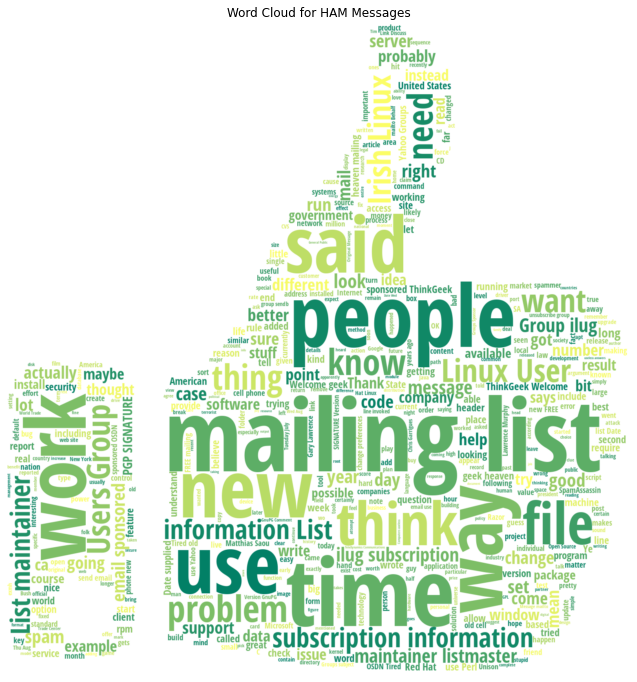

In [22]:
icon = Image.open(THUMBS_UP)
image_mask = Image.new(mode = 'RGB', size = icon.size, color=(255,255,255))
image_mask.paste(icon, box = icon) 

rgb_array = np.array(image_mask) #converts the image object to an array 


word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                       max_words = 500, colormap = 'summer',
                       font_path = CUSTOM_FONT, max_font_size = 300)

word_cloud.generate(HAM_str)

plt.figure(figsize=[20,12])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.title('Word Cloud for HAM Messages')

plt.axis('off')
plt.show()

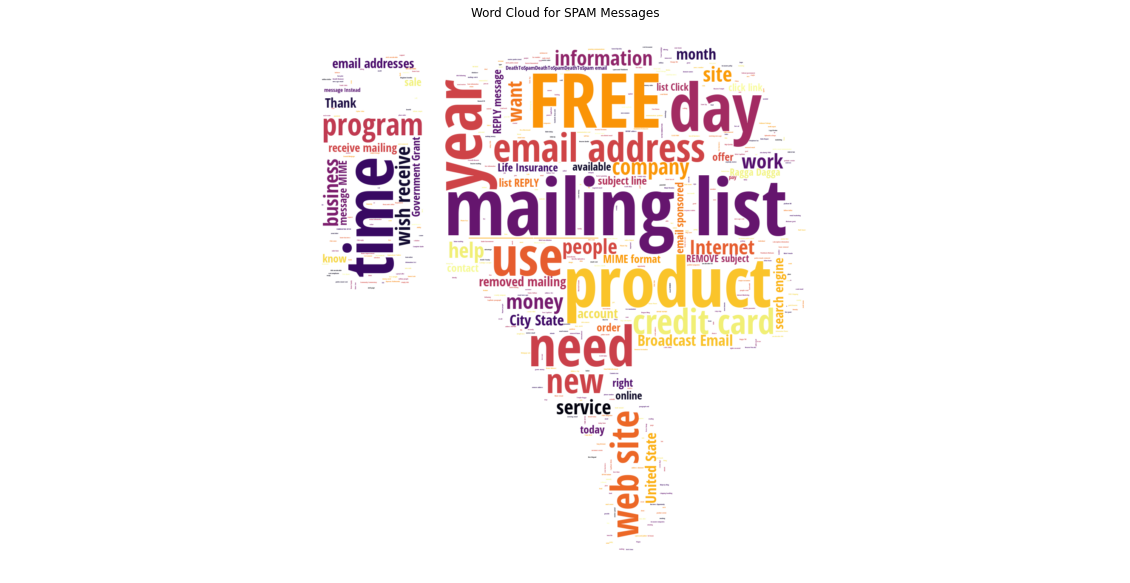

In [23]:
icon = Image.open(THUMBS_DOWN)
image_mask = Image.new(mode = 'RGB', size = icon.size, color=(255,255,255))
image_mask.paste(icon, box = icon) 

rgb_array = np.array(image_mask) #converts the image object to an array 

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                       max_words = 500, colormap = 'inferno', 
                       font_path = CUSTOM_FONT, max_font_size = 300)

word_cloud.generate(SPAM_str)

plt.figure(figsize=[20,12])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.title('Word Cloud for SPAM Messages')
plt.axis('off')
plt.show()

### Distribution by Length of Text within both HAM and SPAM Messages: 

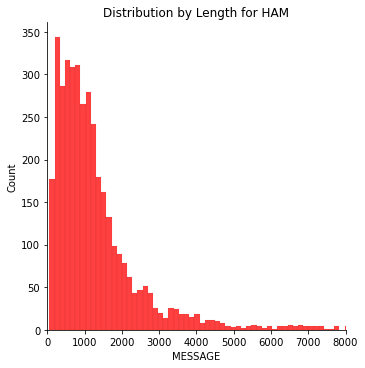

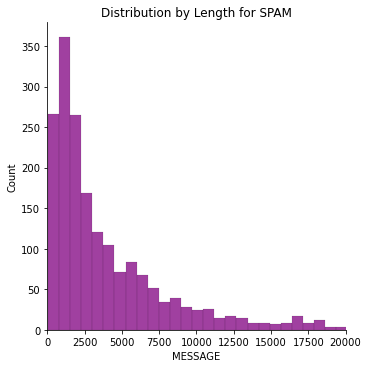

In [24]:
ham =data[data['CATEGORY'] == HAM_CAT]['MESSAGE'].str.len()
sns.displot(ham, label='Ham', color='red')
plt.xlim(0, 8000)
plt.title('Distribution by Length for HAM')

plt.draw()


spam = data[data['CATEGORY'] == SPAM_CAT]['MESSAGE'].str.len()
sns.displot(spam, label='Spam', color='purple')
plt.xlim(0, 20000)
plt.title('Distribution by Length for SPAM')
plt.draw()
plt.legend().set_visible(False)



# plt.savefig('Distrbution of word by length.png')
# transform/ normalise this range from 0 - 1 

In [25]:
#SPAM_words[:10]

In [26]:
data1 = pd.DataFrame.from_dict(Counter(SPAM_str.split()).most_common(10))
data1 = data1.rename(columns={0: "words of spam", 1 : "count_"})

data2 = pd.DataFrame.from_dict(Counter(HAM_str.split()).most_common(10))
data2 = data2.rename(columns={0: "words of ham", 1 : "count_"})

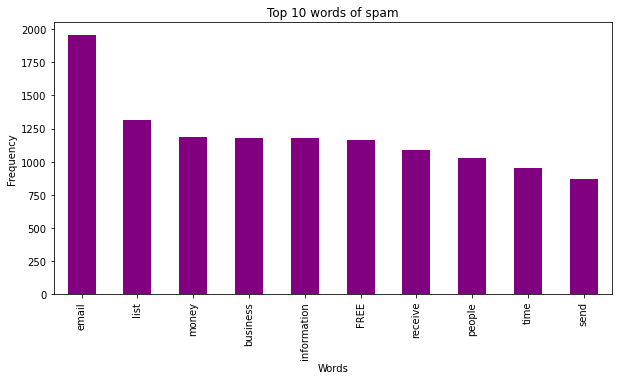

In [27]:
data1.plot.bar(legend = False, color = 'purple',figsize = (10,5))
y_pos = np.arange(len(data1["words of spam"]))
plt.xticks(y_pos, data1["words of spam"])
plt.title('Top 10 words of spam')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.legend().set_visible(False)
plt.show()

#plt.savefig('Top 10 words spam.png',dpi=199)


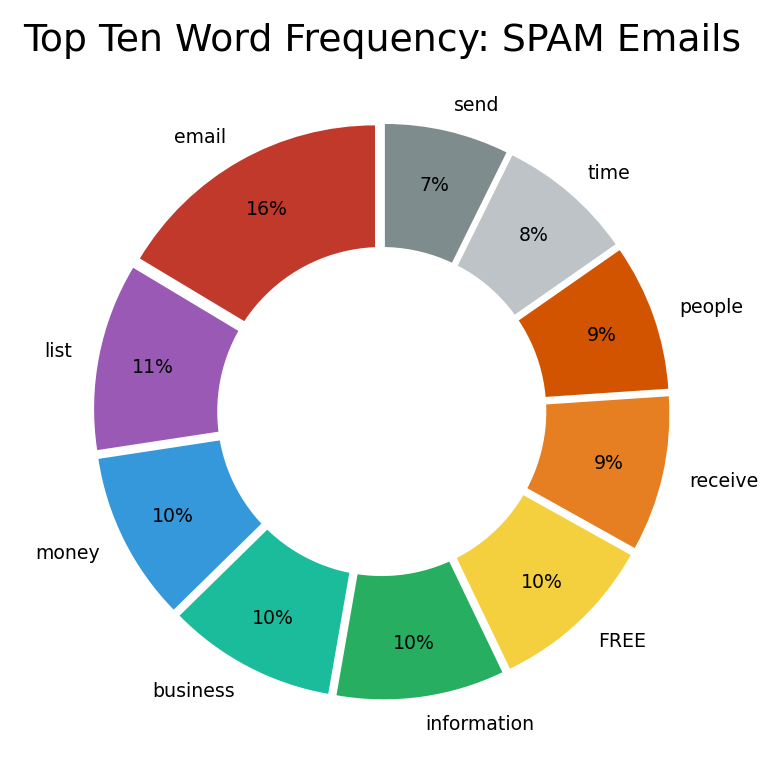

In [28]:
category_names = data1["words of spam"]

sizes = SPAM_words[:10]
custom_colours = ['#C0392B', '#9B59B6', '#3498DB', '#1ABC9C', '#27AE60', 
                  '#F4D03F', '#E67E22','#D35400', '#BDC3C7', '#7F8C8D']

#to "explode"
offset = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(4, 4), dpi=227)
plt.pie(sizes, labels = category_names, textprops={'fontsize':6}, startangle=90, 
        autopct='%1.0f%%', colors = custom_colours,  pctdistance = 0.8, explode = offset)


#draw circle
centre_circle = plt.Circle((0,0), radius = 0.6, fc='white')
plt.gca().add_artist(centre_circle)


#title

plt.title('Top Ten Word Frequency: SPAM Emails')

plt.show()

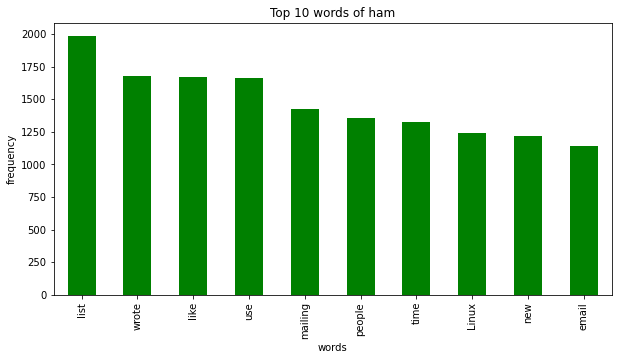

In [29]:
data2.plot.bar(legend = False, color = 'green', figsize = (10,5))
y_pos = np.arange(len(data2["words of ham"]))
plt.xticks(y_pos, data2["words of ham"])
plt.title('Top 10 words of ham')
plt.xlabel('words')
plt.ylabel('frequency')
plt.draw()
plt.legend().set_visible(False)

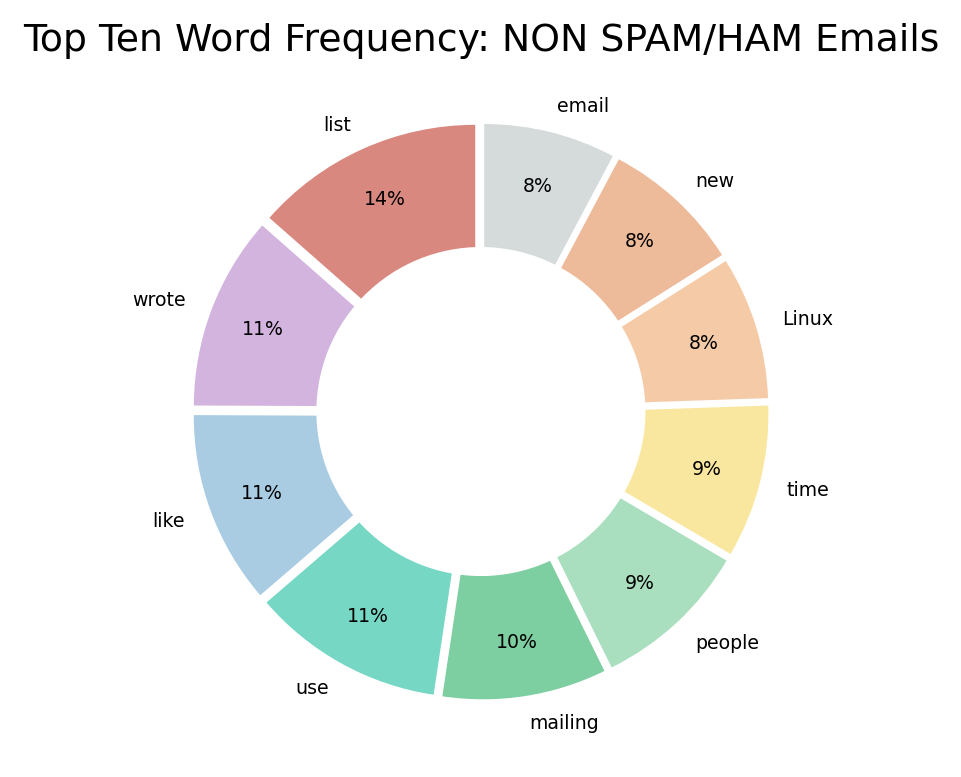

In [30]:
category_names = data2["words of ham"]
#category_names = [word.upper() for word in category_names]

sizes = HAM_words[:10]
custom_colours = ['#D98880', '#D2B4DE', '#A9CCE3', '#76D7C4', '#7DCEA0', 
                  '#A9DFBF', '#F9E79F','#F5CBA7', '#EDBB99', '#D5DBDB']

#to "explode"
offset = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

def absolute_value(val):
    a  = sizes[ numpy.abs(sizes - val/100.*sizes.sum()).argmin() ]
    return a

plt.figure(figsize=(4, 4), dpi=227)

plt.pie(sizes, labels = category_names, textprops={'fontsize':6}, startangle=90, 
        autopct='%1.0f%%', colors = custom_colours,  pctdistance = 0.8, explode = offset)


#draw circle
centre_circle = plt.Circle((0,0), radius = 0.6, fc='white')
plt.gca().add_artist(centre_circle)


#title
plt.title('Top Ten Word Frequency: NON SPAM/HAM Emails')

plt.show()

# Split the Data 

In [31]:
X_train, X_test, y_train, y_test = train_test_split(data.MESSAGE, data.CATEGORY, test_size=0.3, random_state=43)

In [32]:
tfidf_vectorizer = TfidfVectorizer(stop_words=all_stop_words, max_df=0.25) 
# unstand the max_df number and how does it affect the vectorizer 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [33]:
type(X_train)

pandas.core.series.Series

In [34]:
spam_detector_svc = SGDClassifier().fit(tfidf_train, y_train) 
#SGDClassifer is part of sklearn package - linear classifier, sensitive to feature scaling. 
#technically a SVM linear classifer, the training algorithm using ...
#check its loss functions (similar to neural network)

In [35]:
predictions = spam_detector_svc.predict(tfidf_test)


In [36]:
predictions

array([0, 0, 0, ..., 0, 1, 0])

In [37]:
# print("Confusion Matrix")
# print(confusion_matrix(predictions, y_test))

In [87]:
import pickle
classifier_filepath = 'classifier_model.sav'
with open(filename, 'wb') as fid: 
    pickle.dump(spam_detector_svc, fid)

Confusion Matrix


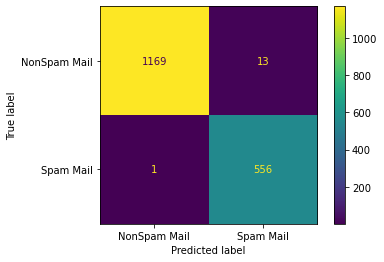

In [38]:
cm = confusion_matrix(predictions, y_test)
target_names = ['NonSpam Mail', 'Spam Mail']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
print("Confusion Matrix")
plt.draw()

In [39]:
#get the False Neg Rates: 
from sklearn.metrics import recall_score
tpr = recall_score(y_test, predictions) 
tnr = recall_score(y_test, predictions) 
fpr = 1 - tnr
fnr = 1 - tpr

print('False Negative Rate: {:.3f}%'.format(fnr))   #FNR for 1st class will be at index 0

False Negative Rate: 0.023%


In [40]:
print("Classificaion Report")

target_names = ['NonSpam Mail', 'Spam Mail']
print(classification_report(y_test, predictions, digits=3, target_names=target_names))
cf = classification_report(y_test, predictions, digits=3, target_names=target_names)

Classificaion Report
              precision    recall  f1-score   support

NonSpam Mail      0.989     0.999     0.994      1170
   Spam Mail      0.998     0.977     0.988       569

    accuracy                          0.992      1739
   macro avg      0.994     0.988     0.991      1739
weighted avg      0.992     0.992     0.992      1739



In [41]:
correct_doc = (y_test == predictions).sum()
numbs_doc_wrong = X_test.shape[0] - correct_doc
print('Docs classified correctly', correct_doc)
print('Docs classified incorrectly', numbs_doc_wrong)

# fraction_wrong = numbs_doc_wrong/ (correct_doc +numbs_doc_wrong)
# print(f' The (testing) accuracy of the model is {1-fraction_wrong:.3%}')

accuracy = accuracy_score(y_test, predictions)
print('SGD Classifier Accuracy of the model: {:.3f}%'.format(accuracy*100))

Docs classified correctly 1725
Docs classified incorrectly 14
SGD Classifier Accuracy of the model: 99.195%


In [42]:
y__test = np.asarray(y_test)
misclassified = np.where(y__test != predictions)
print(misclassified)

(array([  32,  266,  276,  578,  635,  695, 1142, 1229, 1253, 1500, 1574,
       1576, 1682, 1687]),)


In [43]:
#print(data.MESSAGE[695])

In [44]:
for x in misclassified: 
    misclass_data = data.MESSAGE[x]


In [45]:
len(misclass_data)

14

In [46]:
cleaned_misclass = misclass_data.apply(clean_msg_nohtml)
type(cleaned_misclass)

pandas.core.series.Series

In [47]:
for x in cleaned_misclass:
    cleaned_misclass_string = (' '.join(x))

In [48]:
type(cleaned_misclass_string)

str

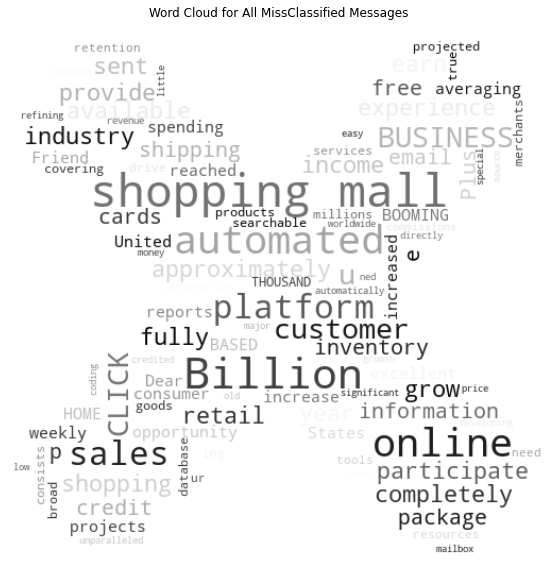

In [49]:
icon = Image.open(X_ICON)
image_mask = Image.new(mode = 'RGB', size = icon.size, color=(255,255,255))
image_mask.paste(icon, box = icon) 

rgb_array = np.array(image_mask) #converts the image object to an array 

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                       max_words = 100, colormap = 'gray')

word_cloud.generate(cleaned_misclass_string)

plt.figure(figsize=[16,10])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.title('Word Cloud for All MissClassified Messages')
plt.axis('off')
plt.show()

In [50]:
from collections import Counter
counted_misclass = Counter(pd.Series(cleaned_misclass_string).str.split().sum())

In [51]:
#counted_misclass.most_common()[:3]

In [52]:
missclass_most_common = counted_misclass.most_common()

In [53]:
type(missclass_most_common)

list

In [54]:
missclass_most_common[:5]

[('shopping', 10), ('mall', 8), ('Billion', 7), ('online', 4), ('platform', 4)]

In [55]:
missclass_data1 = pd.DataFrame.from_dict(Counter(cleaned_misclass_string.split()).most_common(5))
missclass_data1 = missclass_data1.rename(columns={0: "words of missclassed", 1 : "count"})
missclass_data1

,words of missclassed,count
0,shopping,10
1,mall,8
2,Billion,7
3,online,4
4,platform,4


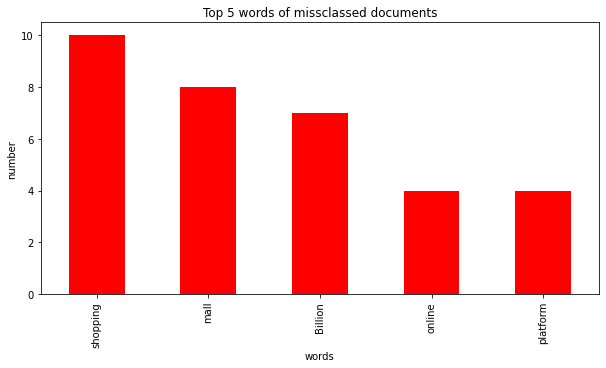

In [56]:
missclass_data1.plot.bar(legend = False, color = 'red', figsize = (10,5))
y_pos = np.arange(len(missclass_data1["words of missclassed"]))
plt.xticks(y_pos, missclass_data1["words of missclassed"])
plt.title('Top 5 words of missclassed documents')
plt.xlabel('words')
plt.ylabel('number')
plt.draw()
plt.legend().set_visible(False)

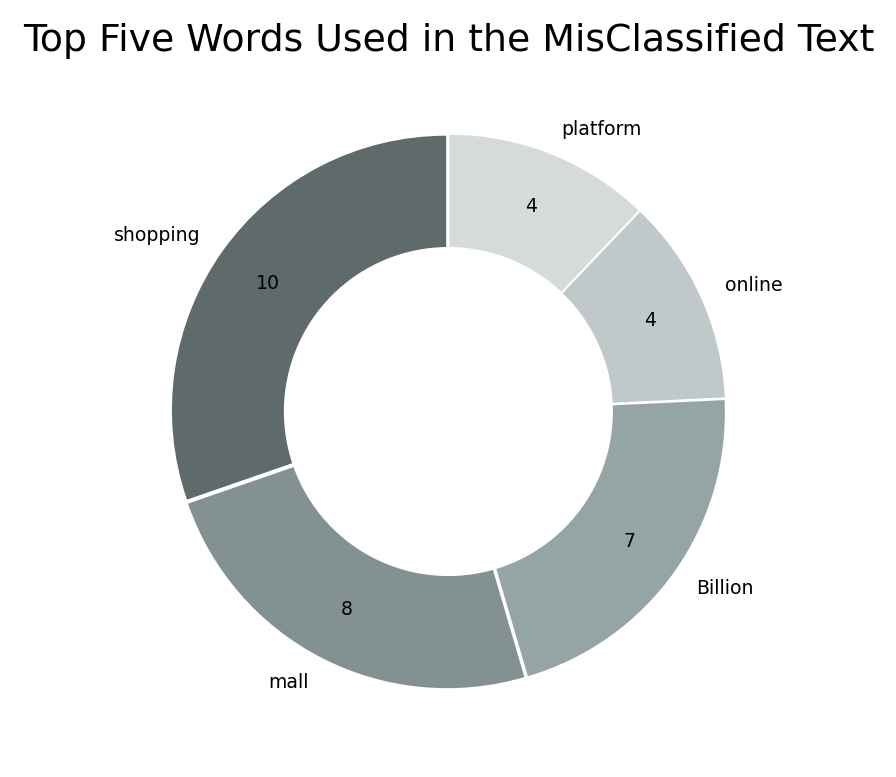

In [57]:
category_names = missclass_data1["words of missclassed"]

sizes = missclass_data1["count"]

custom_colours = ['#5F6A6A', '#839192', '#95A5A6',  '#BFC9CA', '#D5DBDB']

#to "explode"
offset = [0.01, 0.01, 0.01, 0.01, 0.01]

def absolute_value(val):
    a  = sizes[ np.abs(sizes - val/100.*sizes.sum()).argmin() ]
    return a

plt.figure(figsize=(4, 4), dpi=227)
plt.pie(sizes, labels = category_names, textprops={'fontsize':6}, startangle=90, 
        autopct=absolute_value, colors = custom_colours,  pctdistance = 0.8, explode = offset)


#draw circle
centre_circle = plt.Circle((0,0), radius = 0.6, fc='white')
plt.gca().add_artist(centre_circle)


#title
plt.title('Top Five Words Used in the MisClassified Text')

plt.show()

In [58]:
correct_doc

1725

### for a pie chart 


category_names =['Correctly Classified', 'MissClassified']
size = [correct_doc, numbs_doc_wrong]
custom_colours = ['#52F729', '#F73E29']
plt.figure(figsize=(2, 2), dpi=227)
plt.pie(size, labels = category_names, textprops={'fontsize':6}, startangle=90, 
        autopct='%1.0f%%', colors = custom_colours, explode=[0,0.5])
plt.show()



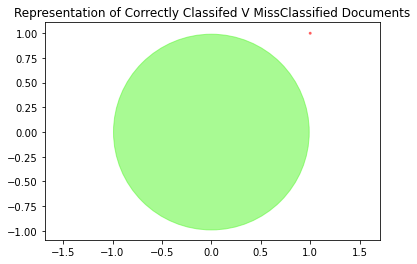

In [59]:
fig, ax = plt.subplots()
ax.add_patch(plt.Circle((0, 0), .99, color='#52F729', alpha=0.5))
ax.add_patch(plt.Circle((1, 1), .01, color='red', alpha=0.5))

#Use adjustable='box-forced' to make the plot area square-shaped as well.
ax.set_aspect('equal', adjustable='datalim')
plt.title('Representation of Correctly Classifed V MissClassified Documents')
#plt.axis('off')
ax.plot()   #Causes an autoscale update.
plt.show()


***NOT WORKING*** 
from pprint import pprint
import circlify

circles = circlify.circlify(missclass_most_common[:5], show_enclosure=True, target_enclosure=circlify.Circle(x=0, y=0, r=1))
	# (necessary) data: A list of positive values sorted from largest to smallest
  	# (optional) target_enclosure: A target enclosure where the packed circles should fit (default to the unit circle (0, 0, 1))
  	# (optional) show_enclosure: A boolean indicating if the target enclosure should be appended to the output (default to False)
pprint(circles)
circlify.bubbles(circles=circles) # Graph of the packed circles

In [60]:
# For plotting the classification results
# from mlxtend.plotting import plot_decision_regions

In [61]:
# X_test_array = X_test.apply(clean_msg_nohtml)
# X_test_array = (X_test).astype(str)
# X_test_array = X_test_array.astype(int)

In [62]:
#plot_decision_regions((X_test).astype(int), (y_test).astype(int), clf = spam_detector_svc, legend = 2)
#plt.title("Decision boundary using SGD Classifier (Test)")
#plt.xlabel("mean_perimeter")
#plt.ylabel("mean_texture")

#print(X_test)

#need to check the training classification error 
#for plotting - 
        #get the probabilty of the classification assignment 'wordX' has a probaility of Y% belonging to SPAM category
        #see if the package has a library to provide these numbers 
        #provide the confidence interval - provide some kind of variation of probability assignment 
        classification for the trianing set accuracy ,  !!!important for the training data - to emlinate the over fitting error 
        

**done**
For visualisation of the results: confusion matrix, and get the 12 miss classified cases to represent them. 
 ---- got the miss classified cases: need to represent them. 
 
 
 
get another independant test set for a blind scenerio - get another independant data set. 

write out ten slides for what I am doing 
compare this with 

neural networks - check out this for spam filters 

In [63]:
NEW_DATASET_SPAM = 'UniversityProject_SpamFilter/NewData_Spam.csv'
NEW_DATASET_HAM = 'UniversityProject_SpamFilter/NewData_Ham.csv'

In [64]:
import sys
import csv

csv.field_size_limit(sys.maxsize)


def new_dataframe_from_directory(path, classification):
    file = open(path)
    csvreader = csv.reader(file)
    header = next(csvreader)
    rows = []
    
    for row in csvreader:
        rows.append({'MESSAGE': row, 'CATEGORY': classification})
        new_dataset_spam = (rows)
    file.close()
    
    return pd.DataFrame(rows) 


# def dataframe_from_directory(path, classification):
#     rows = []
#     row_names = []
    
#     for file_name, email_body in email_body_generator(path):
#         rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
#         row_names.append(file_name) 
    
#     return pd.DataFrame(rows, index=row_names) 

In [65]:
new_spam = new_dataframe_from_directory(NEW_DATASET_SPAM, SPAM_CAT)
new_ham = new_dataframe_from_directory(NEW_DATASET_HAM, HAM_CAT)
new_dataset = pd.concat([new_spam, new_ham])

In [66]:
new_dataset = pd.concat([new_spam, new_ham])

In [67]:
new_dataset.head()

,MESSAGE,CATEGORY
0,[ save up to NUMBER on life insurance why spen...,1
1,[NUMBER fight the risk of cancer URL NUMBER sl...,1
2,[NUMBER fight the risk of cancer URL NUMBER sl...,1
3,[ adult club offers free membership instant ac...,1
4,[i thought you might like these NUMBER slim do...,1


In [68]:
len(new_dataset.CATEGORY)

3000

In [69]:
new_dataset[new_dataset.MESSAGE.str.len() == 0].index #brings back Int64Index([], dtype='int64') meaning data = None) 

Int64Index([], dtype='int64')

In [70]:
#new_dataset.MESSAGE.astype(str).apply(clean_msg_nohtml)

In [71]:
#new_nested_list = new_dataset.MESSAGE.astype(str).apply(clean_msg_nohtml)

In [72]:
new_dataset['LENGTH']=new_dataset['MESSAGE'].astype(str).apply(len)
documents_ids = range(0, len(new_dataset.index))
new_dataset['DOC_ID'] = documents_ids
new_dataset = new_dataset.set_index('DOC_ID')
new_dataset

,MESSAGE,CATEGORY,LENGTH
DOC_ID,,,
0,[ save up to NUMBER on life insurance why spen...,1,998
1,[NUMBER fight the risk of cancer URL NUMBER sl...,1,496
2,[NUMBER fight the risk of cancer URL NUMBER sl...,1,396
3,[ adult club offers free membership instant ac...,1,2474
4,[i thought you might like these NUMBER slim do...,1,415
...,...,...,...
2995,[man killed trying to surf on tube train anano...,0,988
2996,[hi gianni a very good resource for this is UR...,0,1627
2997,[gianni ponzi wrote i have a prob when trying ...,0,335


In [89]:
# load it again
with open(classifier_filepath, 'rb') as fid:
    classifier_loaded = pickle.load(fid)
    

In [90]:
type(classifier_loaded)

sklearn.linear_model._stochastic_gradient.SGDClassifier

In [74]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(new_dataset.MESSAGE, new_dataset.CATEGORY, test_size=0.3, random_state=43)

In [77]:
type(X_train2)


pandas.core.series.Series

In [79]:
new_tfidf_train = tfidf_vectorizer.fit_transform(X_train2.astype(str))
new_tfidf_test = tfidf_vectorizer.transform(X_test2.astype(str))
#predictions2 = spam_detector_svc.predict(new_tfidf_test)

In [80]:
type(new_tfidf_test)

scipy.sparse.csr.csr_matrix

In [97]:
does_ths_work = classifier_loaded.predict(new_tfidf_test)

ValueError: X has 30046 features, but SGDClassifier is expecting 86568 features as input.